# Netbacks Freight Hire Comparison

This script allows you to plot multiple percentages of freight hire included in a given Netback.

This script uses elements from our API code samples. If you'd like a more basic and informative example of how to pull data via the Spark API, please visit our Github or API website:

- Github: https://github.com/spark-commodities/api-code-samples/blob/master/jupyter_notebooks/
- API Website: https://www.sparkcommodities.com/api/code-examples/jupyter.html


### Have any questions?

If you have any questions regarding our API, or need help accessing specific datasets, please contact us at:

__data@sparkcommodities.com__

or refer to our API website for more information about this endpoint:
https://www.sparkcommodities.com/api/request/netbacks.html

__N.B. This script requires a Cargo subscription__

## 1. Importing Data

Here we define the functions that allow us to retrieve the valid credentials to access the Spark API.

This section can remain unchanged for most Spark API users.

In [1]:
import json
import os
import sys
import numpy as np
from base64 import b64encode
from pprint import pprint
from urllib.parse import urljoin
import pandas as pd
import time
import requests
from io import StringIO


try:
    from urllib import request, parse
    from urllib.error import HTTPError
except ImportError:
    raise RuntimeError("Python 3 required")




API_BASE_URL = "https://api.sparkcommodities.com"


def retrieve_credentials(file_path=None):
    """
    Find credentials either by reading the client_credentials file or reading
    environment variables
    """
    if file_path is None:

        client_id = os.getenv("SPARK_CLIENT_ID")
        client_secret = os.getenv("SPARK_CLIENT_SECRET")
        if not client_id or not client_secret:
            raise RuntimeError(
                "SPARK_CLIENT_ID and SPARK_CLIENT_SECRET environment vars required"
            )
    else:
        # Parse the file
        if not os.path.isfile(file_path):
            raise RuntimeError("The file {} doesn't exist".format(file_path))

        with open(file_path) as fp:
            lines = [l.replace("\n", "") for l in fp.readlines()]

        if lines[0] in ("clientId,clientSecret", "client_id,client_secret"):
            client_id, client_secret = lines[1].split(",")
        else:
            print("First line read: '{}'".format(lines[0]))
            raise RuntimeError(
                "The specified file {} doesn't look like to be a Spark API client "
                "credentials file".format(file_path)
            )

    print(">>>> Found credentials!")
    print(
        ">>>> Client_id={}, client_secret={}****".format(client_id, client_secret[:5])
    )

    return client_id, client_secret


def do_api_post_query(uri, body, headers):
    url = urljoin(API_BASE_URL, uri)

    data = json.dumps(body).encode("utf-8")

    # HTTP POST request
    req = request.Request(url, data=data, headers=headers)
    try:
        response = request.urlopen(req)
    except HTTPError as e:
        print("HTTP Error: ", e.code)
        print(e.read())
        sys.exit(1)

    resp_content = response.read()

    # The server must return HTTP 201. Raise an error if this is not the case
    assert response.status == 201, resp_content

    # The server returned a JSON response
    content = json.loads(resp_content)

    return content


def do_api_get_query(uri, access_token):
    url = urljoin(API_BASE_URL, uri)

    headers = {
        "Authorization": "Bearer {}".format(access_token),
        "Accept": "application/json",
    }

    # HTTP POST request
    req = request.Request(url, headers=headers)
    try:
        response = request.urlopen(req)
    except HTTPError as e:
        print("HTTP Error: ", e.code)
        print(e.read())
        sys.exit(1)

    resp_content = response.read()

    # The server must return HTTP 201. Raise an error if this is not the case
    assert response.status == 200, resp_content

    # The server returned a JSON response
    content = json.loads(resp_content)

    return content


def get_access_token(client_id, client_secret):
    """
    Get a new access_token. Access tokens are the thing that applications use to make
    API requests. Access tokens must be kept confidential in storage.

    # Procedure:

    Do a POST query with `grantType` and `scopes` in the body. A basic authorization
    HTTP header is required. The "Basic" HTTP authentication scheme is defined in
    RFC 7617, which transmits credentials as `clientId:clientSecret` pairs, encoded
    using base64.
    """

    # Note: for the sake of this example, we choose to use the Python urllib from the
    # standard lib. One should consider using https://requests.readthedocs.io/

    payload = "{}:{}".format(client_id, client_secret).encode()
    headers = {
        "Authorization": b64encode(payload).decode(),
        "Accept": "application/json",
        "Content-Type": "application/json",
    }
    body = {
        "grantType": "clientCredentials",
        "scopes": "read:netbacks"
    }

    content = do_api_post_query(uri="/oauth/token/", body=body, headers=headers)

    print(
        ">>>> Successfully fetched an access token {}****, valid {} seconds.".format(
            content["accessToken"][:5], content["expiresIn"]
        )
    )

    return content["accessToken"]


def list_netbacks(access_token):
    """
    Fetch available routes. Return contract ticker symbols

    # Procedure:

    Do a GET query to /v1.0/routes/ with a Bearer token authorization HTTP header.
    """
    content = do_api_get_query(uri="/v1.0/netbacks/reference-data/", access_token=access_token)

    print(">>>> All the routes you can fetch")
    tickers = []
    fobPort_names = []

    availablevia = []
    for contract in content["data"]['staticData']['fobPorts']:
        
        #print(contract)
        #print(contract["uuid"])
        tickers.append(contract["uuid"])
        fobPort_names.append(contract['name'])
        
        availablevia.append(contract['availableViaPoints'])
    
    reldates = content["data"]['staticData']['sparkReleases']
    
    dicto1 = content["data"]
        
    return tickers, fobPort_names, availablevia, reldates, dicto1


### N.B. Credentials

N.B. You must have downloaded your client credentials CSV file before proceeding. Please refer to the API documentation if you have not dowloaded them already. Instructions for downloading your credentials can be found here:

https://api.sparkcommodities.com/redoc#section/Authentication/Create-an-Oauth2-Client


In [2]:
#client_id, client_secret = retrieve_credentials(
#    file_path="/tmp/client_credentials.csv"
#)

client_id, client_secret = retrieve_credentials(file_path="/tmp/client_credentials.csv")

# Authenticate:
access_token = get_access_token(client_id, client_secret)

# Fetch all contracts:
tickers, fobPort_names, availablevia, reldates, dicto1 = list_netbacks(access_token)


>>>> Found credentials!
>>>> Client_id=01c23590-ef6c-4a36-8237-c89c3f1a3b2a, client_secret=80763****
>>>> Successfully fetched an access token eyJhb****, valid 604799 seconds.
>>>> All the routes you can fetch


### Netbacks Import Base Functions

In [3]:
## Defining the function
from typing import Literal


def fetch_netback(access_token, ticker, release, via=None, laden=None, ballast=None, percent_hire: Literal[0, 100] = 100):
    """
    For a route, fetch then display the route details

    # Procedure:

    Do GET queries to https://api.sparkcommodities.com/v1.0/routes/{route_uuid}/
    with a Bearer token authorization HTTP header.
    """
    
    query_params = "?fob-port={}".format(ticker)
    if release is not None:
        query_params += "&release-date={}".format(release)
    if via is not None:
        query_params += "&via-point={}".format(via)
    if laden is not None:
        query_params += "&laden-congestion-days={}".format(laden)
    if ballast is not None:
        query_params += "&ballast-congestion-days={}".format(ballast)
    if percent_hire in [0,100]:
        query_params += "&percent-hire={}".format(percent_hire)
    
    content = do_api_get_query(
        uri="/v1.0/netbacks/{}".format(query_params),
        access_token=access_token,
    )
    
    my_dict = content['data']

    return my_dict


# Define formatting data function
def format_store(available_via, fob_names, tickrs):
    dict_store = {
        "Index": [],
        "Callable Ports": [],
        "Corresponding Ticker": [],
        "Available Via": []
    }
    
    c = 0
    for a in available_via:
        ## Check which routes have non-empty Netbacks data and save indices
        if len(a) != 0:
            dict_store['Index'].append(c)

            # Use these indices to retrive the corresponding Netbacks info
            dict_store['Callable Ports'].append(fob_names[c])
            dict_store['Corresponding Ticker'].append(tickrs[c])
            dict_store['Available Via'].append(available_via[c])
        c += 1
    # Show available Netbacks ports in a DataFrame (with corresponding indices)
    dict_df = pd.DataFrame(dict_store)
    return dict_df

def netbacks_history(tick, reldates, my_via=None, laden =None, ballast=None, percent_hire: Literal[0, 100] = 100):

    months = []
    nea_outrights = []
    nwe_outrights = []
    release_date = []
    
    port = []

    for r in reldates:
        try:
            my_dict = fetch_netback(access_token, tickers[tick], release=r, via=my_via, laden=laden, ballast=ballast,percent_hire=percent_hire)
            

            m = my_dict['netbacks'][0]
            
            months.append(m['load']['month'])

            nea_outrights.append(float(m['nea']['outright']['usdPerMMBtu']))

            nwe_outrights.append(float(m['nwe']['outright']['usdPerMMBtu']))

            release_date.append(my_dict['releaseDate'])
            port.append(fobPort_names[tick])
            
        except:
            print('Bad Date: ' + r)
        
        # Incorporating sleep function
        time.sleep(0.5)
        
    historical_df = pd.DataFrame({
                'Release Date': release_date,
                'FoB Port': port,
                'Month': months,
                'NEA Outrights': nea_outrights,
                'NWE Outrights': nwe_outrights,
                })
    
    historical_df['Release Date'] = pd.to_datetime(historical_df['Release Date'])
    
    return historical_df


### Freight Hire Calculations

As the endpoint only allows for 2 options (0% or 100%) for the freight hire percent parameter, we must calculate the netbacks when the cost included is inbetween.

Here, we select 50% as well as the two available options. However, these values can be altered as necessary.

In [10]:
def calculate_netbacks(my_dict_0, my_dict_100, percent_hire_list):


    m = pd.merge(my_dict_0,my_dict_100,how='inner',on=['Release Date','FoB Port','Month'],suffixes=(" 0%", " 100%"))
    m['NEA Base Costs'] = m['NEA Outrights 100%'] - m['NEA Outrights 0%']
    m['NWE Base Costs'] = m['NWE Outrights 100%'] - m['NWE Outrights 0%']

    for percent_hire in percent_hire_list:
            m[f'NEA Outright {percent_hire}%'] = m['NEA Base Costs'] * (percent_hire/100) + m['NEA Outrights 0%']
            m[f'NWE Outright {percent_hire}%'] = m['NWE Base Costs'] * (percent_hire/100) + m['NWE Outrights 0%']

            m[f'Arb {percent_hire}%'] = m[f'NEA Outright {percent_hire}%'] - m[f'NWE Outright {percent_hire}%']


    return m

# 2. Calling data and sorting

In this section, we call the data needed for the US Arb via COGH netback for both 0% Freight Hire and 100% Freight Hire.

### Calling and calculating Netbacks

We select the following Netback.

In [5]:
# Store available netbacks

available_df = format_store(availablevia,fobPort_names,tickers)

In [6]:
# Choose route ID, price release date and freight hire

# Select Route

via ='cogh'
my_t = 'Sabine Pass'
t = fobPort_names.index(my_t)

my_rels = reldates[:200]

percent_hires = [0,50,100]

my_dict_0 = netbacks_history(t,my_rels,via,percent_hire=0)
my_dict_100 = netbacks_history(t,my_rels,via,percent_hire=100)


In [11]:
# Sorting dataframes my load month and adding day of year column

df25 = calculate_netbacks(my_dict_0,my_dict_100,percent_hires)

# View one example of output
df25.head()

,Release Date,FoB Port,Month,NEA Outrights 0%,NWE Outrights 0%,NEA Outrights 100%,NWE Outrights 100%,NEA Base Costs,NWE Base Costs,NEA Outright 0%,NWE Outright 0%,Arb 0%,NEA Outright 50%,NWE Outright 50%,Arb 50%,NEA Outright 100%,NWE Outright 100%,Arb 100%
0,2025-03-24,Sabine Pass,2025-04,12.468,12.482,11.885,12.247,-0.583,-0.235,12.468,12.482,-0.014,12.1765,12.3645,-0.1880,11.885,12.247,-0.362
1,2025-03-21,Sabine Pass,2025-04,12.447,12.499,11.865,12.261,-0.582,-0.238,12.447,12.499,-0.052,12.1560,12.3800,-0.2240,11.865,12.261,-0.396
2,2025-03-20,Sabine Pass,2025-04,12.599,12.612,12.026,12.386,-0.573,-0.226,12.599,12.612,-0.013,12.3125,12.4990,-0.1865,12.026,12.386,-0.360
3,2025-03-19,Sabine Pass,2025-04,12.863,12.810,12.334,12.590,-0.529,-0.220,12.863,12.810,0.053,12.5985,12.7000,-0.1015,12.334,12.590,-0.256
4,2025-03-18,Sabine Pass,2025-04,12.166,12.083,11.695,11.871,-0.471,-0.212,12.166,12.083,0.083,11.9305,11.9770,-0.0465,11.695,11.871,-0.176


# 3. Plotting


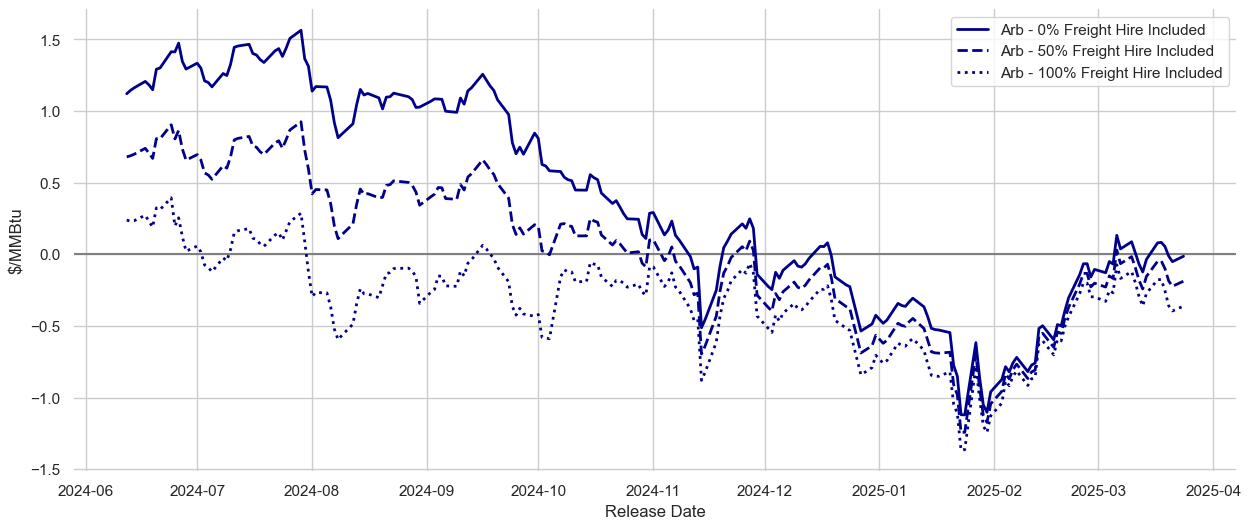

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(15,6))

plt.axhline(0, color='grey')



df25 = df25.sort_values('Release Date',ascending=True)
ax.plot(df25['Release Date'], df25[f'Arb 0%'], color='darkblue', label=f'Arb - 0% Freight Hire Included', linewidth=2)
ax.plot(df25['Release Date'], df25[f'Arb 50%'], color='darkblue', label=f'Arb - 50% Freight Hire Included', linewidth=2,linestyle='--')
ax.plot(df25['Release Date'], df25[f'Arb 100%'], color='darkblue', label=f'Arb - 100% Freight Hire Included', linewidth=2,linestyle='dotted')

plt.ylabel('$/MMBtu')

plt.xlabel('Release Date')

ax.legend()

sns.despine(left=True, bottom=True)